In [1]:
import pandas as pd
from bertopic import BERTopic
from bertopic.representation import PartOfSpeech,MaximalMarginalRelevance,KeyBERTInspired
from sentence_transformers import SentenceTransformer
import joblib
from typing import List, Dict
from sentence_transformers import SentenceTransformer, util
import numpy as np
import torch
import json
import scipy
from src.utils import clean_dataset,list_to_dict,convert_ctfidf,NpEncoder

model = SentenceTransformer('all-MiniLM-L6-v2')

/home/abpal/miniconda3/envs/bertopic_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='all')

import re

def load_model(model:int) :
    """Load the corresponding model based on the model number

    Args:
        model (int): ranging from 1 - 4 
    """
    if model == 1 :
        return BERTopic()
    elif model == 2 :
        representation_model = KeyBERTInspired()
        return BERTopic(representation_model=representation_model)
    elif model == 3 :
        representation_model = PartOfSpeech("en_core_web_sm")
        return BERTopic(representation_model=representation_model)
    else : 
        representation_model = MaximalMarginalRelevance(diversity=0.3)
        return BERTopic(representation_model=representation_model)

def clean_text(text):
    # Remove escape sequences
    text = re.sub(r'\\[a-zA-Z]', ' ', text)

    # Remove email addresses
    text = re.sub(r'\S+@\S+', ' ', text)

    # Remove punctuation
    text = re.sub(r'[^\w\s]', ' ', text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    return text

# Example usage:
text = "Hello, this is an example text with an email address john@example.com. \nPlease remove punctuation and escape sequences, including \\n."
cleaned_text = clean_text(text)
print(cleaned_text)


from tqdm import tqdm

docs = []
for text in tqdm(newsgroups_train["data"]):
  docs.append(clean_text(text))

Hello this is an example text with an email address Please remove punctuation and escape sequences including


100%|██████████| 11314/11314 [00:01<00:00, 11212.87it/s]


In [3]:
docs = []
count = 0
for text in tqdm(newsgroups_train["data"]):
  count+=1
  docs.append(clean_text(text) + f" c_{count}")

topic_model = BERTopic()
topics, probs = topic_model.fit_transform(docs)
topic_model.get_topic_info()



100%|██████████| 11314/11314 [00:01<00:00, 11208.11it/s]


,Topic,Count,Name,Representation,Representative_Docs
0,-1,3780,-1_the_to_of_for,"[the, to, of, for, and, in, is, you, from, it]",[From Bob Sarver Subject Re Question for those...
1,0,504,0_he_year_baseball_team,"[he, year, baseball, team, game, runs, braves,...",[Subject Re Eck vs Rickey was Re Rickey s whin...
2,1,318,1_clipper_encryption_key_chip,"[clipper, encryption, key, chip, escrow, keys,...",[From Clipper Chip Announcement Subject text o...
3,2,209,2_tobacco_health_mail_address,"[tobacco, health, mail, address, smokeless, co...",[Subject Space FAQ 02 15 Network Resources Fro...
4,3,192,3_fbi_batf_fire_compound,"[fbi, batf, fire, compound, atf, koresh, waco,...",[From Jim De Arras Subject Re BATF FBI Murders...
...,...,...,...,...,...
221,220,10,220_depression_islamic_marriage_rice,"[depression, islamic, marriage, rice, sex, fre...",[From Fred Rice Subject Re Ancient islamic rit...
222,221,10,221_icons_program_esc_swetsky,"[icons, program, esc, swetsky, manager, cica, ...",[From Paul Blackman Subject Re moving icons Ar...
223,222,10,222_video_card_s3_seetharam,"[video, card, s3, seetharam, srini, watchit, b...",[From Glenn T Jayaputera Subject Need Info on ...
224,223,10,223_callison_scum_warning_senegal,"[callison, scum, warning, senegal, macintyre, ...",[From Joe Karolchik Subject Re WARNING please ...


In [4]:
def centroid_ablation(word:str,document:str) -> float:
    """Take word out from document and see how much document embedding moves. 

    Args:
        word (str): the input word
        document (str): the input document 

    Returns:
        float: the movement of the document embedding. 
    """
    document_embed = model.encode(document, convert_to_tensor=True)
    document_without_word = document.replace(word, "")
    document_without_word_embed = model.encode(document_without_word, convert_to_tensor=True)
    return float(torch.linalg.norm(document_embed-document_without_word_embed))
    
# centroid_ablation("The","The bird is on the tree. The cat is eating the bird.")


def get_spearman_rho(ctf_idf_json_topic1, ctf_idf_json_topic2):
    # print(ctf_idf_json_topic1, ctf_idf_json_topic2)
    words1 = list(ctf_idf_json_topic1.keys())
    ctf_idf_rankings1 = [ctf_idf_json_topic1[word] for word in words1]
    # print(f'Numbers for key {i}: {numbers_for_key}')
    x = ctf_idf_rankings1

    ctf_idf_rankings2 = [ctf_idf_json_topic2[word] for word in words1]
    # print(f'Numbers for key {i}: {numbers_for_key}')
    y = ctf_idf_rankings2
    rho, p_value = scipy.stats.spearmanr(x, y)
    return rho, p_value

In [5]:
def raw_centroid_checks( docs: List[str], k: int, model: int) -> pd.DataFrame:
    """
    Take as input a list of documents, a speicific number of topics to run the check for,
    and the model. 
    1. Run a basic bertopic model to fit_transform the dataset.
    2. For each topic in 1 to k :
        2.1 Remove each repn word. 
        2.2 Check how much on avg the document embeddings change. 
    """
    final_ablation_mappings = {}
    anchor_topic_model = load_model(model)
    topics, probs = anchor_topic_model.fit_transform(docs)
    topic_list = anchor_topic_model.get_topic_info()
    c_tf_idf_mappings = anchor_topic_model.topic_representations_
    c_tf_idf_mappings = convert_ctfidf(c_tf_idf_mappings)

    documents = anchor_topic_model.get_topic_info()["Representative_Docs"]

    df_basic_mapping = pd.DataFrame({"Document": docs, "Topic": topics})

    for topic_i in tqdm(range(k)):
        topic_documents = df_basic_mapping[df_basic_mapping['Topic'] == topic_i]["Document"]
        ablation_mappings = {}
        for word in c_tf_idf_mappings[topic_i].keys():
            centroid_movement = []
            for document in topic_documents :
                centroid_movement.append(centroid_ablation(word,document))
            ablation_mappings[word] = np.mean(centroid_movement)
        final_ablation_mappings[topic_i] = get_spearman_rho(c_tf_idf_mappings[topic_i],ablation_mappings)
    return final_ablation_mappings

raw_centroid_checks(docs,2,1)

100%|██████████| 2/2 [01:27<00:00, 43.95s/it]


{0: (0.8424242424242423, 0.0022200312259168407),
 1: (0.8424242424242423, 0.0022200312259168407)}

In [9]:
def run_centroid_ablation( docs: List[str], k: int, model: int, repeats: int, save_path: str)->None:
    """_summary_

    Args:
        docs (List[str]): _description_
        k (int): _description_
        model (int): _description_
        repeats (int): _description_
        save_path (str): _description_
    """

    to_save = {}
    for _ in range(repeats) : 
        to_save[_] = raw_centroid_checks(docs,k,model)
    
    with open(save_path, 'w') as json_file:
        json.dump(to_save, json_file)

In [10]:
run_centroid_ablation(docs = docs , k = 100, model = 1, repeats = 1, save_path= "final_result/centroid/centroid_1.json")

100%|██████████| 100/100 [09:28<00:00,  5.68s/it]


In [11]:
run_centroid_ablation(docs = docs , k = 100, model = 2, repeats = 1, save_path= "final_result/centroid/centroid_2.json")

 96%|█████████▌| 96/100 [09:49<00:11,  2.80s/it] /home/abpal/miniconda3/envs/bertopic_env/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
100%|██████████| 100/100 [10:00<00:00,  6.01s/it]


In [12]:
run_centroid_ablation(docs = docs , k = 100, model = 3, repeats = 1, save_path= "final_result/centroid/centroid_3.json")

100%|██████████| 100/100 [10:04<00:00,  6.04s/it]


In [13]:
run_centroid_ablation(docs = docs , k = 100, model = 4, repeats = 1, save_path= "final_result/centroid/centroid_4.json")

100%|██████████| 100/100 [10:13<00:00,  6.14s/it]


In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

def read_json_and_plot(filename):
    # Read JSON file
    with open(filename, 'r') as file:
        data = json.load(file)
    
    # Extract x and y values
    x_values = []
    y_values = []
    for key in data:
        # Iterate through inner dictionary
        inner_dict = data[key]
        for inner_key in inner_dict:
            x_values.append(inner_dict[inner_key][0])  # First number in each item
            y_values.append(inner_dict[inner_key][1])  # Second number in each item

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(x_values, y_values, 'bo', label='Data Points')
    plt.title('Normal Plot')
    plt.xlabel('X values')
    plt.ylabel('Y values')
    plt.grid(True)
    plt.legend()

    # Calculate mean and standard deviation
    x_mean = np.mean(x_values)
    y_mean = np.mean(y_values)
    x_std = np.std(x_values)
    y_std = np.std(y_values)
    print(f"Mean of X values: {x_mean}")
    print(f"Mean of Y values: {y_mean}")
    print(f"Standard deviation of X values: {x_std}")
    print(f"Standard deviation of Y values: {y_std}")

    plt.show()

# Usage
# read_json_and_plot('your_json_file.json')


Mean of X values: 0.3276565393712657
Mean of Y values: 0.3352166303842618
Standard deviation of X values: 0.3340139118689276
Standard deviation of Y values: 0.2897470976645502


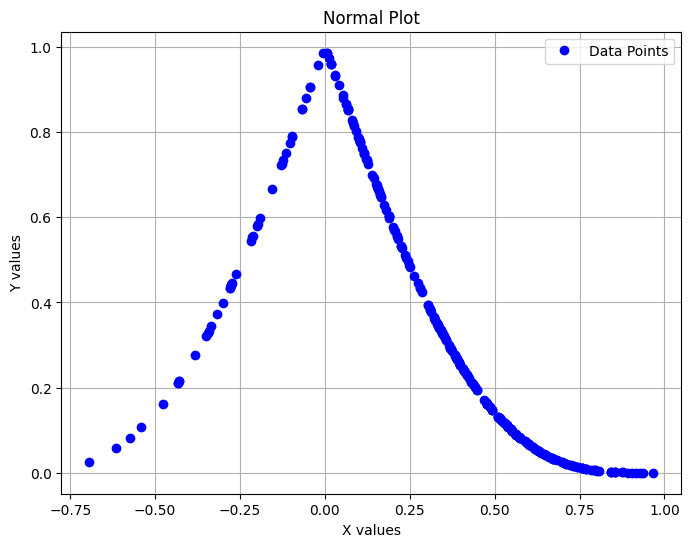

In [5]:
read_json_and_plot("final_result/centroid/centroid_4.json")